PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance. In scikit-learn, PCA is implemented as a transformer object that learns  components in its fit method, and can be used on new data to project it on these components.

PCA centers but does not scale the input data for each feature before applying the SVD. The optional parameter whiten=True makes it possible to project the data onto the singular space while scaling each component to unit variance. This is often useful if the models down-stream make strong assumptions on the isotropy of the signal: this is for example the case for Support Vector Machines with the RBF kernel and the K-Means clustering algorithm.

more [here](https://scikit-learn.org/stable/modules/decomposition.html#pca)

Principal component analysis (PCA).

Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD.

It uses the LAPACK implementation of the full SVD or a randomized truncated SVD by the method of Halko et al. 2009, depending on the shape of the input data and the number of components to extract.

It can also use the scipy.sparse.linalg ARPACK implementation of the truncated SVD.



[sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_normal = pd.read_csv('./data/normal_training.csv')

In [3]:
test_faulty = pd.read_csv('./data/faulty_testing.csv')

In [4]:
import numpy as np
import sklearn.decomposition
import sklearn.preprocessing

## Preparing the data

In [5]:
df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]

In [6]:
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

In [7]:
df_test = train_normal[(train_normal.simulationRun>5)&(train_normal.simulationRun<10)].iloc[:,3:]

# Model PCA

In [8]:
class ModelPCA:
        
    # spe: squared prediction errors
    def spe (self, X, X_pred): 
        return np.sum((X-X_pred)**2, axis=1)
   
    def train(self, df_train):
        
        self.mu_train = df_train.mean(axis=0)
        self.std_train = df_train.std(axis=0)
        
        # Simply set n_components to be float, and it will be used as a 
        # lower bound of explained variance.
        self.m = sklearn.decomposition.PCA() 
        # here we are not use n_components=0.9 
        # just use every component

        X_train = sklearn.preprocessing.scale(df_train)
        # Transform data back to its original space.
        X_train_pred = self.m.inverse_transform(self.m.fit_transform(X_train)) 
        
        return self.spe(X_train, X_train_pred) # return spe
            
    def test(self, df_test):
        
        # standardizing test data according to the mu and std of training set
        X_test = np.array((df_test-self.mu_train)/self.std_train) 
        X_test_pred = self.m.inverse_transform(self.m.transform(X_test))

        return self.spe(X_test, X_test_pred)

# Training Data

In [9]:
models = {'PCA': ModelPCA()}
detection_limits = {}

for name, model in models.items():
    
    spe_train = model.train(df_train)
    spe_validation = model.test(df_validation)
    spe_test = model.test(df_test)
    
    detection_limits[name] = np.percentile(spe_validation, 99.99)

In [10]:
detection_limits

{'PCA': 5.308223963373167e-28}

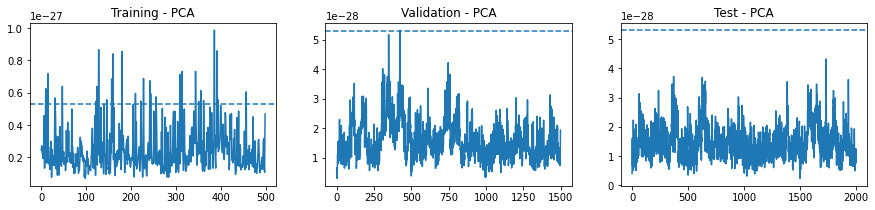

In [11]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(spe_train)
plt.title(f'Training - PCA')
plt.axhline(detection_limits['PCA'], ls = '--')

plt.subplot(1,3,2)
plt.plot(spe_validation)
plt.title(f'Validation - PCA')
plt.axhline(detection_limits['PCA'], ls = '--')

plt.subplot(1,3,3)
plt.plot(spe_test)
plt.title(f'Test - PCA')
plt.axhline(detection_limits['PCA'], ls = '--')

# Testing Data

PCA    44.625
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
PCA,99.0,97.375,0.0,0.125,18.625,98.75,37.0,95.375,0.0,0.125,7.0,92.625,88.0,94.875,0.0,0.875,58.375,91.0,0.0,13.375


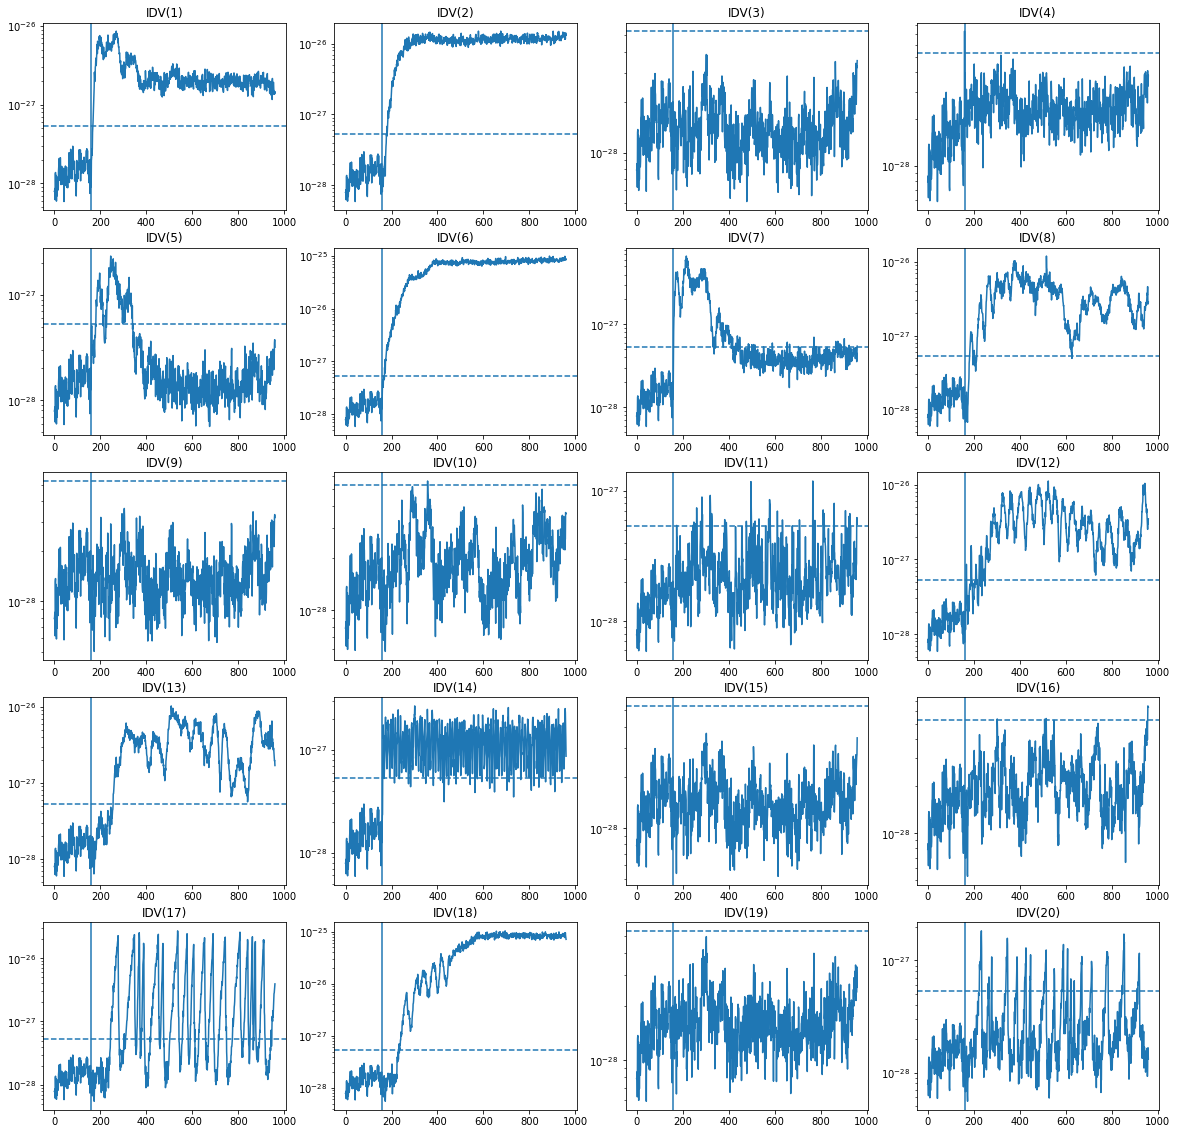

In [12]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []

    for i in range(20):

        df_test = test_faulty[(test_faulty.faultNumber==i+1) & (test_faulty.simulationRun==1)].iloc[:,3:]

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean()) # average of the detection error for every type of disturbance   
100*fdr_df.T

# Model PCA with n_components30

In [13]:
class ModelPCA30:
    # spe: squared prediction errors
    def spe (self, X, X_pred): 
        return np.sum((X-X_pred)**2, axis=1)
   
    def train(self, df_train):
        
        self.mu_train = df_train.mean(axis=0)
        self.std_train = df_train.std(axis=0)
        
        # Simply set n_components to be float, and it will be used as a 
        # lower bound of explained variance.
        self.m = sklearn.decomposition.PCA(n_components=30) 
        # here we are not use n_components=0.9 
        # just use every component

        X_train = sklearn.preprocessing.scale(df_train)
        # Transform data back to its original space.
        X_train_pred = self.m.inverse_transform(self.m.fit_transform(X_train)) 
        
        return self.spe(X_train, X_train_pred) # return spe
            
    def test(self, df_test):
        
        # standardizing test data according to the mu and std of training set
        X_test = np.array((df_test-self.mu_train)/self.std_train) 
        X_test_pred = self.m.inverse_transform(self.m.transform(X_test))

        return self.spe(X_test, X_test_pred)

# Training

In [14]:
models = {'PCA30': ModelPCA30()}
detection_limits = {}

for name, model in models.items():
    
    spe_train = model.train(df_train)
    spe_validation = model.test(df_validation)
    spe_test = model.test(df_test)
    
    detection_limits[name] = np.percentile(spe_validation, 99.99)

In [15]:
detection_limits

{'PCA30': 25.4456610939317}

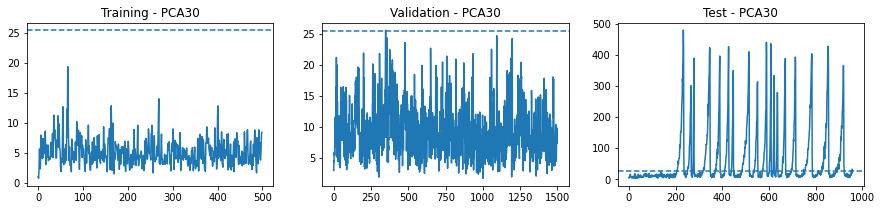

In [16]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(spe_train)
plt.title(f'Training - PCA30')
plt.axhline(detection_limits['PCA30'], ls = '--')

plt.subplot(1,3,2)
plt.plot(spe_validation)
plt.title(f'Validation - PCA30')
plt.axhline(detection_limits['PCA30'], ls = '--')

plt.subplot(1,3,3)
plt.plot(spe_test)
plt.title(f'Test - PCA30')
plt.axhline(detection_limits['PCA30'], ls = '--')

# Testing

PCA30    58.99375
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
PCA30,99.625,98.0,0.75,87.25,15.625,100.0,99.25,96.75,0.75,12.25,37.375,96.375,90.5,99.875,0.875,22.625,81.625,92.5,2.625,45.25


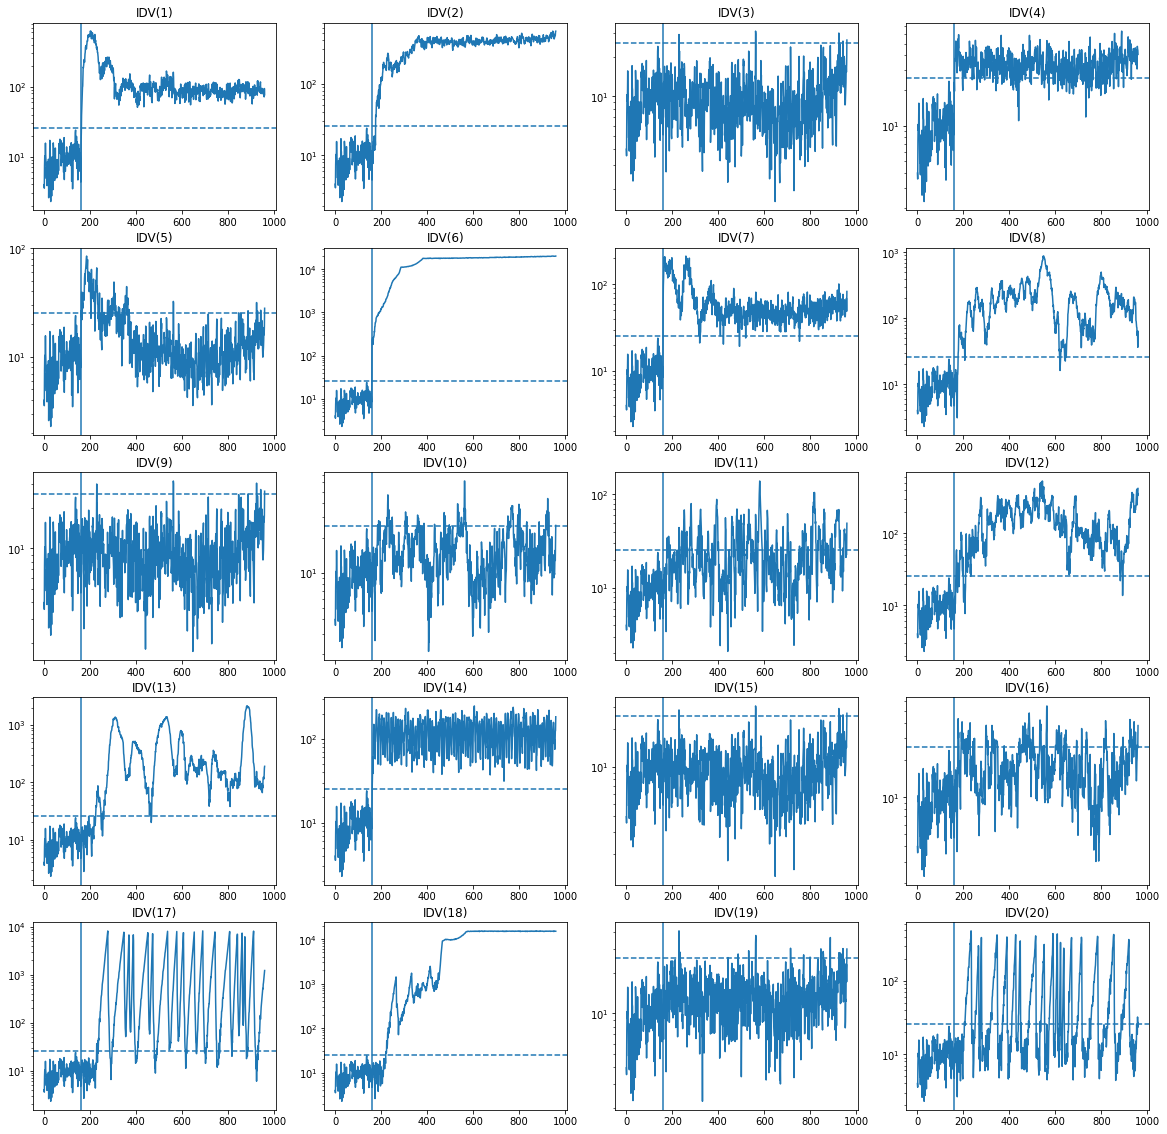

In [17]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []

    for i in range(20):

        df_test = test_faulty[(test_faulty.faultNumber==i+1) & (test_faulty.simulationRun==1)].iloc[:,3:]

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean()) # average of the detection error for every type of disturbance 
100*fdr_df.T

In [18]:
spe_test

[array([  3.97590596,   3.5430462 ,   7.49128819,  10.29985236,
          9.16653318,  10.09891023,  15.59260096,  10.77806636,
          9.02803563,   6.36098457,   4.85215834,   6.98815322,
          4.00686858,   3.84893616,   8.36161347,   5.38950466,
          7.62800952,   5.63615881,   3.98948294,   9.17157513,
          2.58421005,   5.52149747,   8.29245279,   4.80744746,
          7.70165554,  17.07717967,  11.62539567,  11.22798388,
          2.88353577,   2.28144951,   7.12007572,   8.63180111,
          3.88378609,   2.74046729,   6.85373614,   9.91864174,
          4.66792565,   6.44532793,   5.48593215,   3.37831818,
         15.70322288,  13.28667146,   6.7311244 ,   7.91349086,
          6.6868743 ,   5.77179689,   4.5689336 ,   6.02619697,
          7.63949295,  13.26310867,   7.44420318,   4.94579248,
          8.3348827 ,   8.74629142,   7.67668472,   9.0645142 ,
          5.00711912,   8.15101314,   8.5403383 ,   6.54566437,
          5.59050759,   9.10032321,   9.

In [19]:
fdr

[0.99625,
 0.98,
 0.0075,
 0.8725,
 0.15625,
 1.0,
 0.9925,
 0.9675,
 0.0075,
 0.1225,
 0.37375,
 0.96375,
 0.905,
 0.99875,
 0.00875,
 0.22625,
 0.81625,
 0.925,
 0.02625,
 0.4525]

In [20]:
# fdr_df.to_csv('./experimental_result_csv/pca30.csv')

## Lag variables

In [21]:
def apply_lag (df, lag = 1):
       
    from statsmodels.tsa.tsatools import lagmat
    array_lagged = lagmat(df, maxlag=lag,
                          trim="forward", original='in')[lag:,:]  
    new_columns = []
    for l in range(lag):
        new_columns.append(df.columns+'_lag'+str(l+1))
    columns_lagged = df.columns.append(new_columns)
    index_lagged = df.index[lag:]
    df_lagged = pd.DataFrame(array_lagged, index=index_lagged,
                             columns=columns_lagged)
       
    return df_lagged  

## Noise filtering

In [22]:
def filter_noise_ma (df, WS = 100,reduction = False):

    import copy
    
    new_df = copy.deepcopy(df)

    for column in df:
        new_df[column] = new_df[column].rolling(WS).mean()

    if reduction:
        return new_df.drop(df.index[:WS])[::WS]
    else:
        return new_df.drop(df.index[:WS])

## Adding lag variables

pca_lag1    59.756250
pca_lag2    61.051314
pca_lag3    63.020050
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
pca_lag1,99.500000,98.000000,0.25,99.875,13.000000,100.0,100.0,97.750000,0.25,5.875000,59.375000,97.375000,90.500000,100.0,0.125,12.000000,81.750000,92.125000,3.000000,44.375000
pca_lag2,99.624531,98.122653,0.00,100.000,16.645807,100.0,100.0,97.872340,0.00,8.510638,66.332916,98.372966,91.239049,100.0,0.000,14.267835,82.978723,92.615770,8.760951,45.682103
pca_lag3,99.749373,98.621554,0.00,100.000,21.303258,100.0,100.0,97.994987,0.00,13.032581,73.433584,98.746867,92.982456,100.0,0.000,21.804511,84.962406,92.982456,15.664160,49.122807


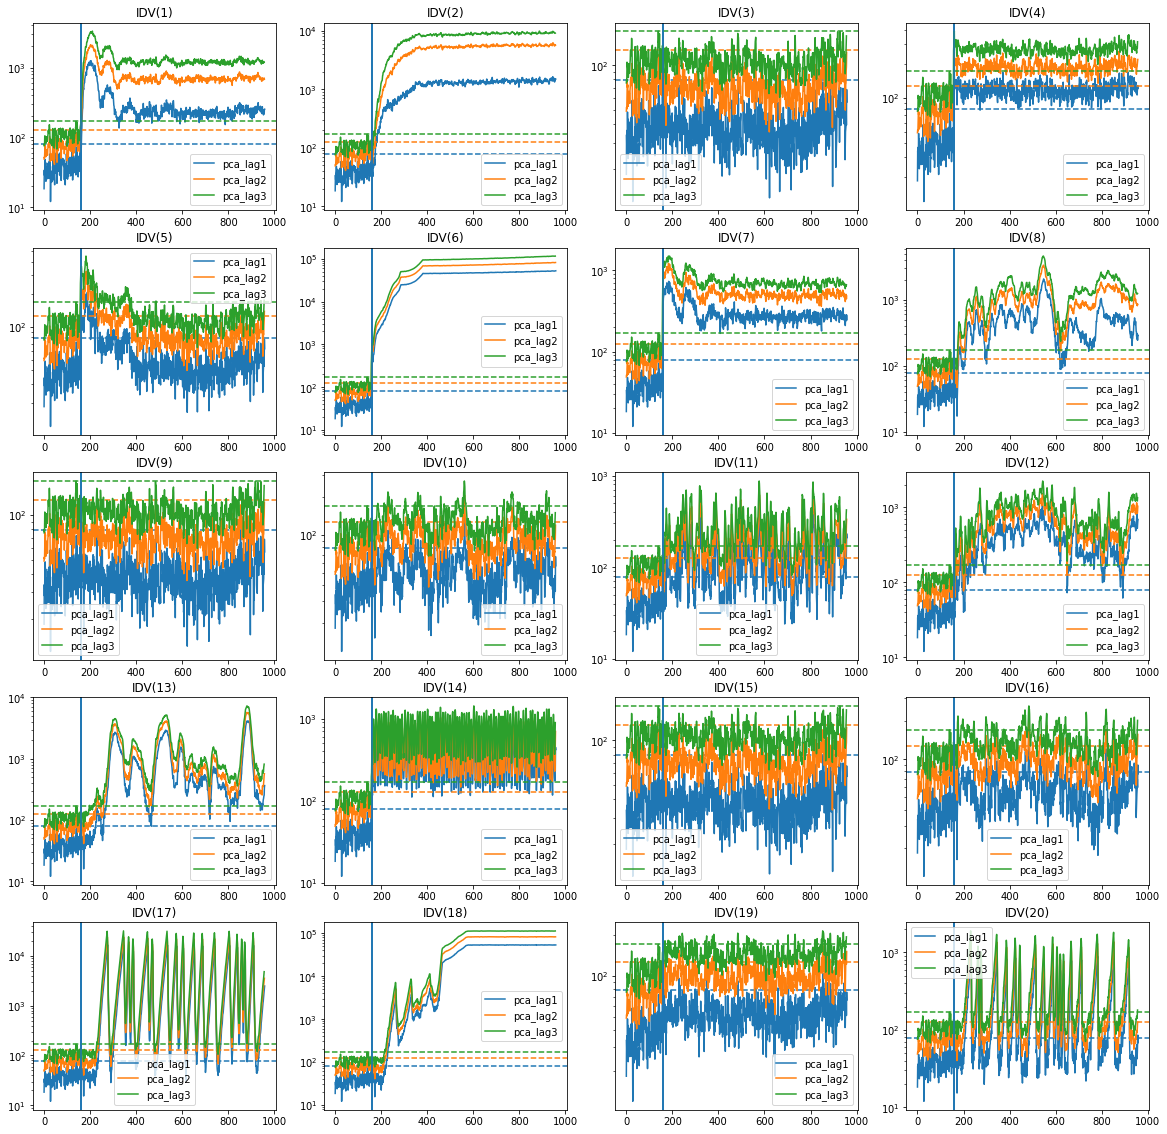

In [23]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

models = {'pca_lag1': ModelPCA30(), 'pca_lag2': ModelPCA30(), 'pca_lag3': ModelPCA30()}
lags = {'pca_lag1': 1, 'pca_lag2': 2, 'pca_lag3': 3}

detection_limits = {}

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []
    
    _ = model.train(apply_lag(df_train,lags[name]))
    spe_validation = model.test(apply_lag(df_validation,lags[name]))
    detection_limits[name] = np.percentile(spe_validation, 99.99)

    for i in range(20):
        
        df_test = apply_lag(test_faulty[(test_faulty.faultNumber==i+1) & 
                                        (test_faulty.simulationRun==1)].iloc[:,3:], lags[name])

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color, label=name)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        ax.ravel()[i].legend()
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean())
100*fdr_df.T

In [24]:
# fdr_df.to_csv('./experimental_result_csv/pcalag.csv')

## Filter noise

WS_10     66.22500
WS_50     61.40000
WS_100    57.79375
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
WS_10,99.250,98.125,0.625,99.625,99.5,99.875,99.875,97.625,1.000,25.625,79.875,98.625,93.625,47.500,0.75,31.250,91.000,93.125,1.125,66.500
WS_50,98.625,97.125,0.125,98.500,99.0,99.500,99.375,96.750,0.250,16.000,55.875,89.375,92.000,1.625,0.00,8.000,90.375,91.875,0.500,93.125
WS_100,98.250,96.250,3.125,95.750,98.5,99.375,98.750,91.125,3.125,6.250,11.500,86.500,89.875,0.500,0.00,1.125,90.000,91.125,2.375,92.375


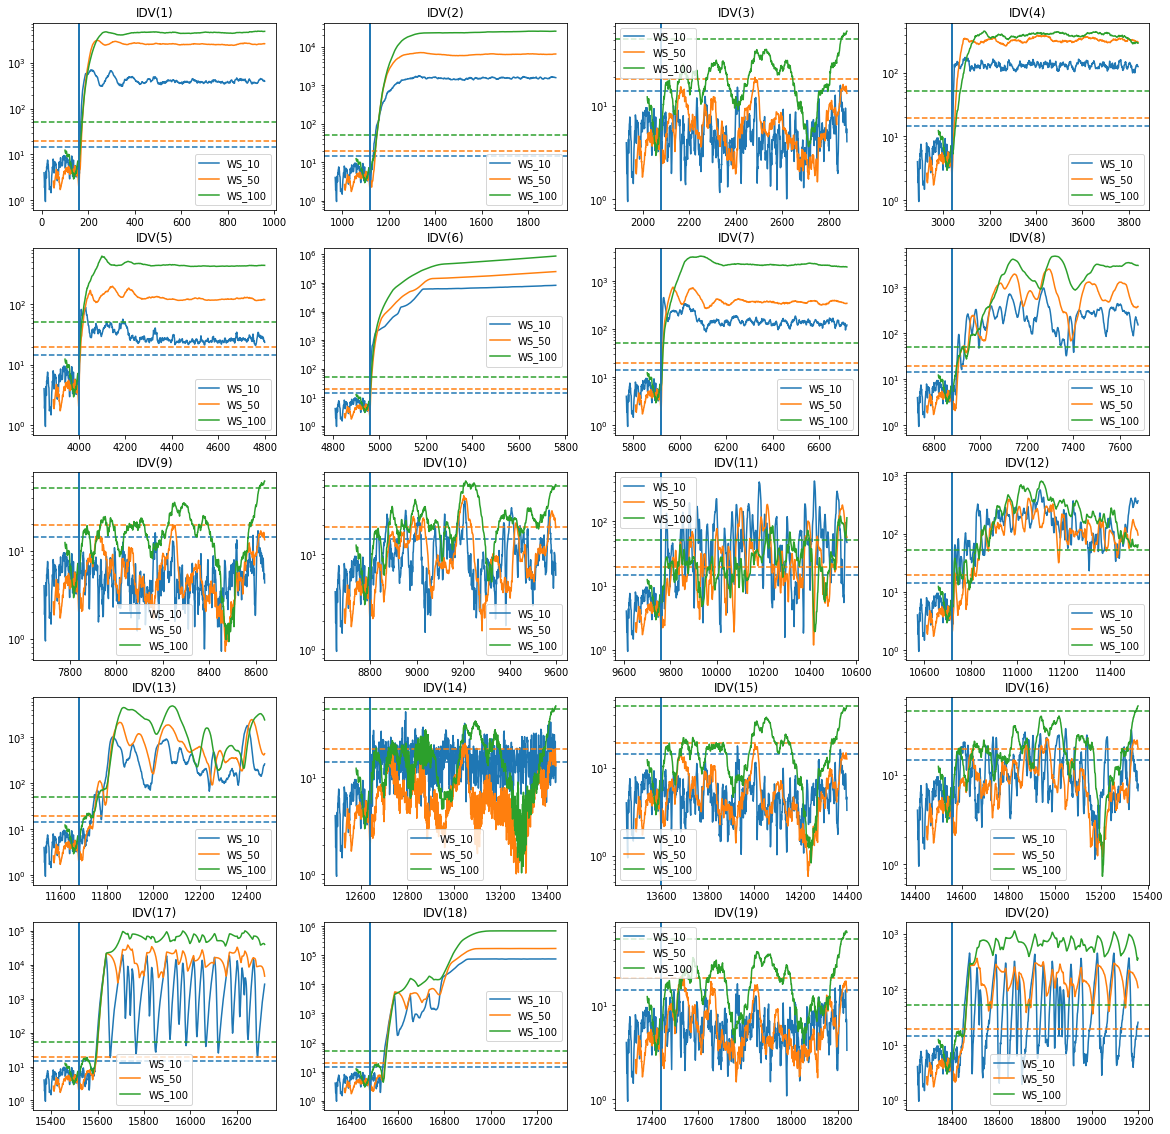

In [25]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

models = {'WS_10': ModelPCA30(), 'WS_50': ModelPCA30(), 'WS_100': ModelPCA30()}
WS = {'WS_10': 10, 'WS_50': 50, 'WS_100': 100}

detection_limits = {}

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []
    
    _ = model.train(filter_noise_ma(df_train,WS[name]))
    spe_validation = model.test(filter_noise_ma(df_validation, WS[name]))
    detection_limits[name] = np.percentile(spe_validation, 99.99)

    for i in range(20):
        
        df_test = filter_noise_ma(test_faulty[(test_faulty.faultNumber==i+1) & 
                                                 (test_faulty.simulationRun==1)].iloc[:,3:], WS[name])

        spe_test.append(model.test(df_test))

        fault_occurrence = df_test.index[0]-WS[name]+160

        fdr.append(np.mean(spe_test[i][160-WS[name]:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(df_test.index, spe_test[i], color = color, label=name)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)#, color = color)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        ax.ravel()[i].legend()
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean())
100*fdr_df.T

In [26]:
# fdr_df.to_csv('./experimental_result_csv/pcanf.csv')